__Project Statement:__<br><br>
Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.
The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows.<br>
●	Buoy<br>
●	Cruise_ship<br>
●	Ferry_boat<br>
●	Freight_boar<br>
●	Gondola<br>
●	Inflatable_boat<br>
●	Kayak<br>
●	Paper_boat<br>
●	Sailboat<br><br>
Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.<br><br>
__As a deep learning engineer:__<br>
1.	Built a CNN network to classify the boat.<br>
2.	Built a lightweight model with the aim of deploying the solution on a mobile device using transfer learning.MobileNetV2 is a popular lightweight pre-trained model built using Keras API.


In [30]:
#Importing required libraries

import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import keras
from keras import backend as K

In [3]:
!unzip -q /content/boat_classification.zip

**1. Build a CNN network to classify boats**

In [4]:
from pathlib import Path

# Define the path to the directory
image_dir = Path('./boat_classification')

# Create the directory if it does not exist
if not image_dir.exists():
    image_dir.mkdir(parents=True, exist_ok=True)
    print(f"Directory created at {image_dir}")
else:
    print(f"Directory already exists at {image_dir}")

Directory created at boat_classification


In [5]:
import os

# Print current working directory
print("Current Working Directory:", os.getcwd())

# List the contents of the current directory
print("Contents of Current Directory:", os.listdir('.'))

Current Working Directory: /content
Contents of Current Directory: ['.config', 'paper_boat', 'buoy', 'ferry_boat', 'boat_classification.zip', 'boat_classification', 'gondola', 'freight_boat', 'kayak', 'cruise_ship', 'inflatable_boat', 'sailboat', 'sample_data']


In [7]:
image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))

image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df

,Filepath,Label
0,boat_classification/sailboat/297.jpg,sailboat
1,boat_classification/gondola/62.jpg,gondola
2,boat_classification/cruise_ship/41.jpg,cruise_ship
3,boat_classification/inflatable_boat/7.jpg,inflatable_boat
4,boat_classification/kayak/95.jpg,kayak
...,...,...
1157,boat_classification/cruise_ship/84.jpg,cruise_ship
1158,boat_classification/sailboat/12.jpg,sailboat
1159,boat_classification/sailboat/103.jpg,sailboat
1160,boat_classification/gondola/188.jpg,gondola


In [8]:
image_df['Label'].value_counts()

,count
Label,
sailboat,389
kayak,203
gondola,193
cruise_ship,191
ferry_boat,63
buoy,53
paper_boat,31
freight_boat,23
inflatable_boat,16


In [9]:
# Consider only images in the “TRAIN” folder and split dataset into train and test in the ratio 70:30, with shuffle and random state=1
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=43)

Load the Image Data

In [10]:
# Use keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator.
# Generators are required to avoid out of memory issues while training.

# Both generators will be initialized with data normalization. (Hint: rescale=1./255)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
# Load train, validation and test dataset in batches of 32 using the generators initialized in the above step.


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 744 validated image filenames belonging to 9 classes.
Found 185 validated image filenames belonging to 9 classes.
Found 233 validated image filenames belonging to 9 classes.


In [12]:
# Build a CNN network using Keras

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# Compile the model with adam optimizer, categorical_crossentropy loss and accuracy metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [14]:
# Train the model for 50 epochs and Early stopping while monitoring validation loss
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - categorical_accuracy: 0.1940 - loss: 2.0938 - precision: 0.2175 - recall: 0.0060 - val_categorical_accuracy: 0.3730 - val_loss: 1.7892 - val_precision: 0.6667 - val_recall: 0.1081
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - categorical_accuracy: 0.3392 - loss: 1.8350 - precision: 0.3924 - recall: 0.0257 - val_categorical_accuracy: 0.3730 - val_loss: 1.7512 - val_precision: 0.7500 - val_recall: 0.0162
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - categorical_accuracy: 0.3319 - loss: 1.8159 - precision: 0.6966 - recall: 0.0190 - val_categorical_accuracy: 0.3730 - val_loss: 1.7552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - categorical_accuracy: 0.3310 - loss: 1.7982 - precision: 0.4133 - recall: 0.0077 - val_categorical_accuracy: 0.3730 - val_loss: 1.7512 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - cate

In [15]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

Max. Training Accuracy 0.4099462330341339
Max. Validaiton Accuracy 0.45945945382118225


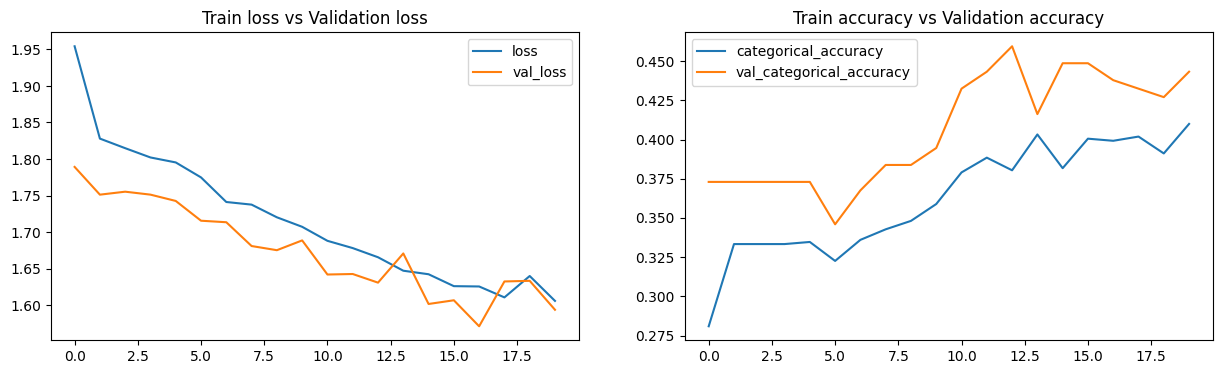

In [16]:
plotModelHistory(history)

In [17]:
# Evaluate the model on test images print the test loss and accuracy

model_results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(model_results[0]))
print("Test Accuracy: {:.2f}%".format(model_results[1] * 100))

    Test Loss: 1.63758
Test Accuracy: 40.34%


**The test loss and test accuracy for CNN model is very poor.**

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


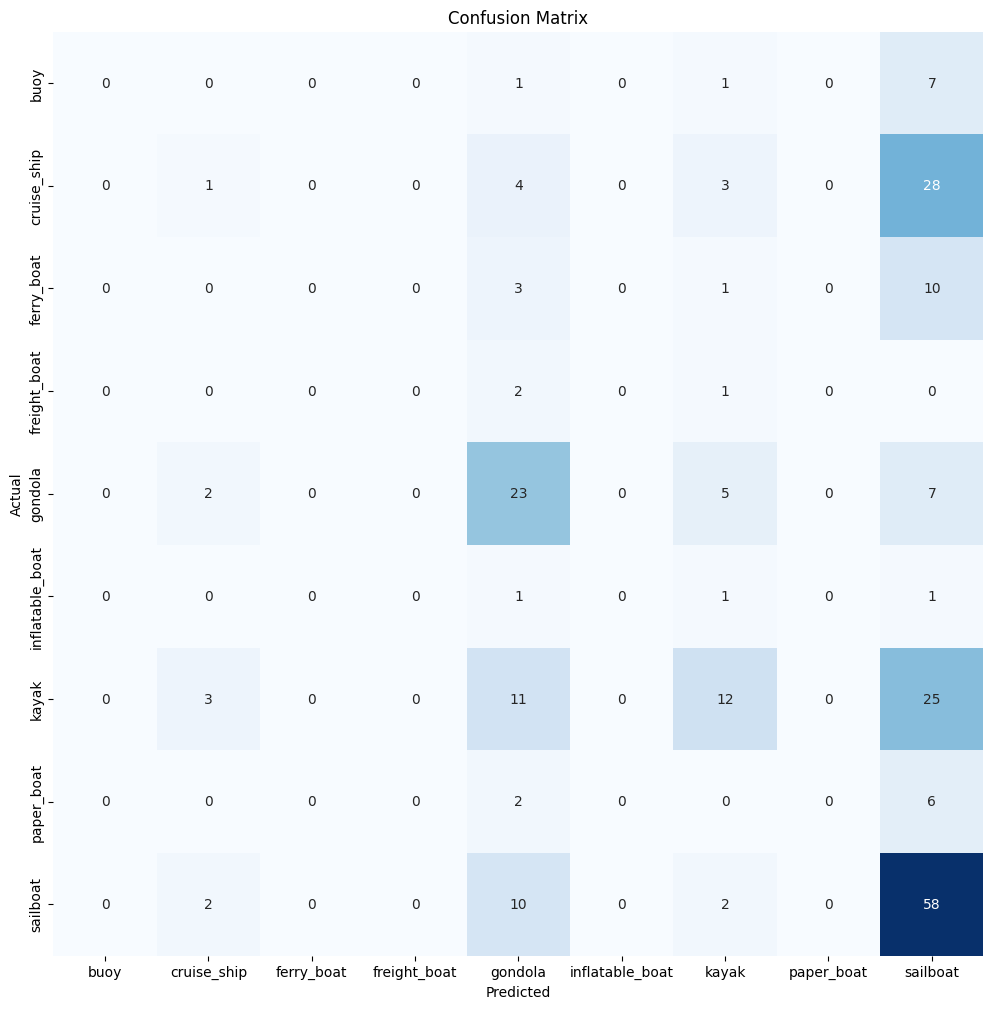

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         9
    cruise_ship       0.12      0.03      0.05        36
     ferry_boat       0.00      0.00      0.00        14
   freight_boat       0.00      0.00      0.00         3
        gondola       0.40      0.62      0.49        37
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.46      0.24      0.31        51
     paper_boat       0.00      0.00      0.00         8
       sailboat       0.41      0.81      0.54        72

       accuracy                           0.40       233
      macro avg       0.16      0.19      0.15       233
   weighted avg       0.31      0.40      0.32       233



In [18]:
# Plot heatmap of the confusion matrix and print classification report.

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

From the Classification report and Confusion Matrix, we can see that the CNN model is not able to correctly classify the classes buoy, ferry_boat, freight_boat, inflatable_boat and paper_boat.

**ROC AUC Score**

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

mobilenet_auc = roc_auc_score(test_images.labels, model.predict(test_images), multi_class="ovr")
print("CNN Model ROC AUC Score is {}".format(mobilenet_auc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 993ms/step
CNN Model ROC AUC Score is 0.6577694673258487


**2. Build a MobileNetV2 lightweight model to classify boats with the aim of deploying the solution in a mobile device.**

In [20]:
# Build a lightweight model CNN network using Keras MobileNetV2

mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', input_shape= (224, 224, 3), include_top=False)
mobilenet.trainable = False

mobilenet_model = keras.models.Sequential([
                             mobilenet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(9, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
# Compile the model with adam optimizer, categorical_crossentropy loss and accuracy metrics
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [22]:
# Train the model for 50 epochs and Early stopping while monitoring validation loss
history_1 = mobilenet_model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.4327 - loss: 1.8084 - precision_1: 0.5916 - recall_1: 0.3171 - val_categorical_accuracy: 0.8108 - val_loss: 0.7041 - val_precision_1: 0.9398 - val_recall_1: 0.6757
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.8773 - loss: 0.4192 - precision_1: 0.9398 - recall_1: 0.8250 - val_categorical_accuracy: 0.8541 - val_loss: 0.5166 - val_precision_1: 0.9484 - val_recall_1: 0.7946
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - categorical_accuracy: 0.9321 - loss: 0.2659 - precision_1: 0.9525 - recall_1: 0.9014 - val_categorical_accuracy: 0.8595 - val_loss: 0.5033 - val_precision_1: 0.9255 - val_recall_1: 0.8054
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - categorical_accuracy: 0.9422 - loss: 0.2052 - precision_1: 0.9600 - recall_1: 0.9181 - val_categorical_accuracy: 0.8811 - val_loss: 0.4610 - val_precision_1: 0.9398 - val_recall_1: 0.8432
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45

Max. Training Accuracy 0.9865591526031494
Max. Validaiton Accuracy 0.8810811042785645


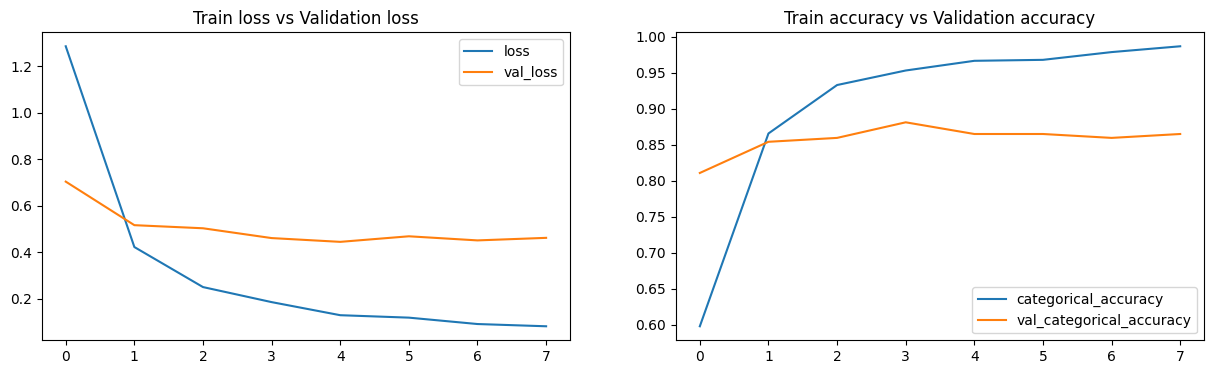

In [23]:
plotModelHistory(history_1)

In [24]:
# Evaluate the model on test images print the test loss and accuracy

mobilenet_results = mobilenet_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(mobilenet_results[0]))
print("Test Accuracy: {:.2f}%".format(mobilenet_results[1] * 100))

    Test Loss: 0.66504
Test Accuracy: 78.97%


**The MobileNetV2 model's Test loss and accuracy are far better than the CNN model.**

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


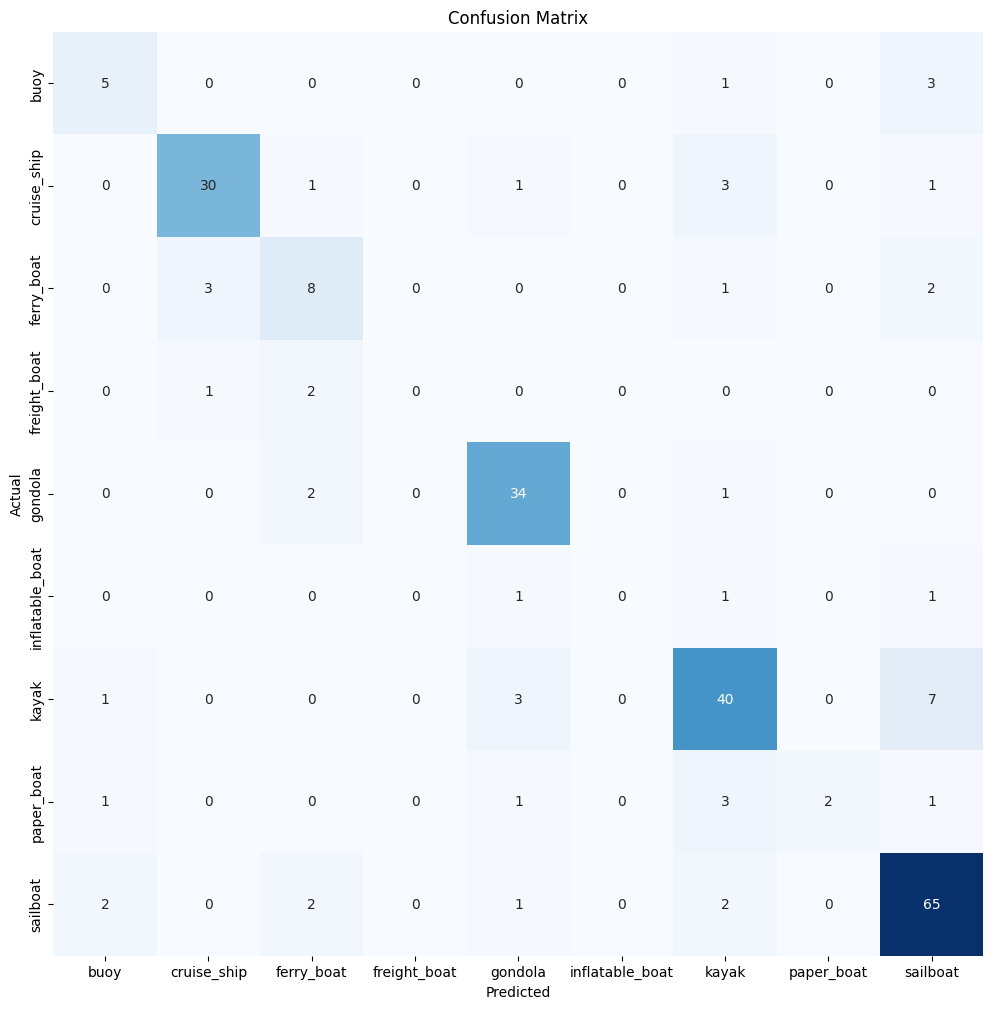

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.56      0.56      0.56         9
    cruise_ship       0.88      0.83      0.86        36
     ferry_boat       0.53      0.57      0.55        14
   freight_boat       0.00      0.00      0.00         3
        gondola       0.83      0.92      0.87        37
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.77      0.78      0.78        51
     paper_boat       1.00      0.25      0.40         8
       sailboat       0.81      0.90      0.86        72

       accuracy                           0.79       233
      macro avg       0.60      0.54      0.54       233
   weighted avg       0.78      0.79      0.77       233



In [25]:
# Plot heatmap of the confusion matrix and print classification report.

predictions = np.argmax(mobilenet_model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [26]:

mobilenet_auc = roc_auc_score(test_images.labels, mobilenet_model.predict(test_images), multi_class="ovr")
print("MobileNetV2 Model ROC AUC Score is {}".format(mobilenet_auc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
MobileNetV2 Model ROC AUC Score is 0.9301767707100892


**3. Compare the results of both models built in step 1 and 2.**

*The loss and accuracy on test images of both the models are as follows.*

In [27]:
print("    CNN Model Test Loss: {:.5f}".format(model_results[0]))
print("CNN Model Test Accuracy: {:.2f}%".format(model_results[1] * 100))

    CNN Model Test Loss: 1.63758
CNN Model Test Accuracy: 40.34%


In [28]:
print("    MobileNet Model Test Loss: {:.5f}".format(mobilenet_results[0]))
print("MobileNet Model Test Accuracy: {:.2f}%".format(mobilenet_results[1] * 100))

    MobileNet Model Test Loss: 0.66504
MobileNet Model Test Accuracy: 78.97%


In [29]:
print("MobileNet Model Test Accuracy is {:.2f}% better than CNN Model Test Accuracy".format(model_results[1] / mobilenet_results[1]  * 100))

MobileNet Model Test Accuracy is 51.09% better than CNN Model Test Accuracy


**Few Observations are as below**

- MobileNet Model Test Accuracy is better than CNN Model Test Accuracy
- The test accuracy and test loss graphs are more smoother in MobileNet model.
- For MobileNet Model EarlyStopping callback is triggered in earlier epochs than CNN model and hence lesser training time.
- These results proves that transfer learning approach is better to classify Boats